# Boosting Implementation

#### In this Jupyter notebook, I implement the Adaptive Boosting algorithm and use it to (binarily) classify horses based on clinical features. The objective is to predict whether a sick horse will survive, using real-world medical data collected from veterinary cases—the same dataset that was used in the previous KNN model. 

#### Since Boosting builds an ensemble of weak classifiers that correct each other’s errors, this method is expected to perform better than individual models like KNN. The dataset’s real-world noise and categorical features make it a strong candidate for boosting because boosting emphasizes learning from hard-to-classify examples.

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

## Import & Filter the Data
Done in the same way as in the KNN algorithm (first dropping some columns, then dropping rows with missing values, then encoding non-numerical columns)

In [2]:
# Load the dataset
df = pd.read_csv("horse.csv")

# Drop less useful columns
df = df.drop(columns=[
    'hospital_number', 'lesion_1', 'lesion_2', 'lesion_3',
    'cp_data', 'nasogastric_reflux_ph', 'abdomo_appearance', 'abdomo_protein'
])

# Drop rows with any missing values in the remaining columns
df_clean = df.dropna().copy()

# Define mappings for categorical features in order to encode these columns
mappings = {
    'surgery': {'no': 0, 'yes': 1},
    'age': {'young': 0, 'adult': 1},
    'temp_of_extremities': {'normal': 1, 'warm': 2, 'cool': 3, 'cold': 4},
    'peripheral_pulse': {'normal': 1, 'increased': 2, 'reduced': 3, 'absent': 4},
    'mucous_membrane': {
        'normal_pink': 1,
        'bright_pink': 2,
        'pale_pink': 3,
        'pale_cyanotic': 4,
        'bright_red': 5,
        'dark_cyanotic': 6
    },
    'capillary_refill_time': {'less_3_sec': 1, 'more_3_sec': 2},
    'pain': {
        'alert': 1,
        'depressed': 2,
        'mild_pain': 3,
        'severe_pain': 4,
        'extreme_pain': 5
    },
    'peristalsis': {'hypermotile': 1, 'normal': 2, 'hypomotile': 3, 'absent': 4},
    'abdominal_distention': {'none': 1, 'slight': 2, 'moderate': 3, 'severe': 4},
    'nasogastric_tube': {'none': 0, 'slight': 1, 'significant': 2},
    'nasogastric_reflux': {'none': 0, 'less_1_liter': 1, 'more_1_liter': 2},
    'rectal_exam_feces': {
        'normal': 1,
        'increased': 2,
        'decreased': 3,
        'absent': 4
    },
    'abdomen': {
        'normal': 1,
        'firm': 2,
        'distend_small': 3,
        'distend_large': 4,
        'other': 5
    },
    'outcome': {'lived': 1, 'died': 0, 'euthanized': 0},  # Binary classification
    'surgical_lesion': {'no': 0, 'yes': 1}
}

# Apply mappings to encode non-numerical columns
for col, mapping in mappings.items():
    if col in df_clean.columns: #prevents mapping over map and getting NaNs
        if df_clean[col].dtype == 'object':  # only map if it's still categorical
            df_clean[col] = df_clean[col].map(mapping)

# Confirm encoding
#print(df_clean.head(10))

## Boosting Algorithm

### First, make decision stumps (the weaker learners)

This class defines the **weak learner** used in the Adaptive Boosting Algorithm: a one-level decision tree, or "decision stump." Each stump makes a binary decision based on a single feature and a threshold.

#### Attributes:
- `feature_index`: the index of the feature this stump uses to split the data.
- `threshold`: the value that the feature is compared against.
- `polarity`: determines the direction of the inequality. If `polarity = 1`, values less than the threshold are classified as -1. If `polarity = -1`, values greater than or equal to the threshold are classified as -1.
- `alpha`: the weight of this stump in the final Adaptive Boosting prediction (assigned during boosting, not used here).

#### `predict(X)` Method:
Given an input matrix `X`, this method:
1. Initializes all predictions to +1.
2. Looks at the specified feature column (`feature_index`).
3. Applies the threshold and polarity rule to set some predictions to -1.
4. Returns the predicted labels as a NumPy array.

In [3]:
class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = 1
        self.alpha = None
    
    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        feature_values = X[:, self.feature_index]
        
        if self.polarity == 1:
            predictions[feature_values < self.threshold] = -1
        else:
            predictions[feature_values >= self.threshold] = -1
        return predictions

### Then, make the adaptive boosting part (the strong classifier)

This class implements the Adaptive Boosting algorithm for binary classification using decision stumps as weak learners. The algorithm trains `n_estimators` stumps sequentially, each focusing more on examples that were misclassified by previous stumps.

#### `__init__(self, n_estimators=10)`
Initializes the AdaBoost model.
- `n_estimators`: the number of weak learners (decision stumps) to train.
- `self.stumps`: a list to store the trained stumps.

#### `fit(self, X, y)`
Trains the AdaBoost model on the training data.

Steps:
1. Initializes uniform sample weights `w`.
2. For each boosting round:
   - Finds the best decision stump by looping through all features, thresholds, and polarities, evaluating each one based on **weighted classification error**.
   - Selects the stump with the lowest error and stores its `feature_index`, `threshold`, and `polarity`.
   - Calculates the model’s weight (`alpha`) based on its error:
     ```
     alpha = 0.5 * log((1 - error) / (error + epsilon))
     ```
   - Updates the sample weights `w`, increasing them for misclassified points.
   - Normalizes the weights so they sum to 1.
   - Appends the trained stump to the list.

#### `predict(self, X)`
Generates predictions by aggregating all stumps' outputs.
- Each stump’s prediction is weighted by its `alpha`.
- Final prediction is the **sign of the sum** of all weighted predictions.

This class works with labels encoded as `-1` and `+1`, which is standard in AdaBoost.


In [4]:
class AdaBoost:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.stumps = []
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.full(n_samples, 1 / n_samples)
        self.stumps = []

        for _ in range(self.n_estimators):
            stump = DecisionStump()
            min_error = float('inf')

            for feature_i in range(n_features):
                feature_values = X[:, feature_i]
                thresholds = np.unique(feature_values)
                
                for threshold in thresholds:
                    for polarity in [1, -1]:
                        predictions = np.ones(n_samples)
                        if polarity == 1:
                            predictions[feature_values < threshold] = -1
                        else:
                            predictions[feature_values >= threshold] = -1

                        misclassified = w[y != predictions]
                        error = sum(misclassified)

                        if error < min_error:
                            min_error = error
                            stump.polarity = polarity
                            stump.threshold = threshold
                            stump.feature_index = feature_i

            EPS = 1e-10
            stump.alpha = 0.5 * np.log((1 - min_error) / (min_error + EPS))

            predictions = stump.predict(X)
            w *= np.exp(-stump.alpha * y * predictions)
            w /= np.sum(w)

            self.stumps.append(stump)
    
    def predict(self, X):
        stump_preds = [stump.alpha * stump.predict(X) for stump in self.stumps]
        final_preds = np.sum(stump_preds, axis=0)
        return np.sign(final_preds)

## Train the Model

In [5]:
# Define features and target
X = df_clean.drop(columns=['outcome']).values
y = df_clean['outcome'].values

# Convert labels to {-1, +1} for AdaBoost
y = np.where(y == 1, 1, -1)

# Train/test split of 80/20 again 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Initialize the AdaBoost model with an arbitrary number of weak learners (decision stumps) (n=10)
model = AdaBoost(n_estimators=10)

# Train the AdaBoost model on the training data
# This involves sequentially training weak learners and updating sample weights
model.fit(X_train, y_train)

# Make predictions on the test set using the trained ensemble
y_pred = model.predict(X_test)

## Result

In [7]:
# Evaluate the model by comparing predicted labels with true labels
# Accuracy is the proportion of correctly predicted samples
acc = accuracy_score(y_test, y_pred)

# Print the result with four decimal places
print(f"AdaBoost Accuracy: {acc:.4f}")

AdaBoost Accuracy: 0.7273


### Discussion: Initial Accuracy

The initial AdaBoost model achieves an accuracy of **72.7%**, which is nearly identical to the result from our earlier KNN classifier. While this is a decent starting point, it's not particularly impressive — especially given that boosting is designed to outperform simpler models by focusing on difficult-to-classify examples.

This result suggests that the default setup (10 decision stumps) may not be optimal for this dataset. AdaBoost’s power comes from **iteratively correcting mistakes**, so we now proceed to test whether increasing the number of weak learners (stumps) improves classification performance.

### Plotting Accuracy vs. Number of Estimators in AdaBoost

This function helps us evaluate how the number of weak learners (decision stumps) affects the performance of the AdaBoost model.

The function loops over a range of values for `n_estimators` (from 1 to `max_estimators`). For each value of `n`, it trains an AdaBoost model with that number of stumps and computes its accuracy on the test set. The results are collected and plotted to visualize how accuracy changes as more stumps are added.

This plot seeks to answer an important tuning question: **Is our initial model underpowered due the choice in the number of decision stumps?**

In [9]:
def plot_adaboost_accuracy_vs_estimators(X_train, X_test, y_train, y_test, max_estimators=20):
    accuracies = []
    estimator_range = range(1, max_estimators + 1)
    
    for n in estimator_range:
        model = AdaBoost(n_estimators=n)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(estimator_range, accuracies, marker='o')
    plt.xlabel("Number of Estimators")
    plt.ylabel("Accuracy")
    plt.title("AdaBoost Accuracy vs. Number of Estimators")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

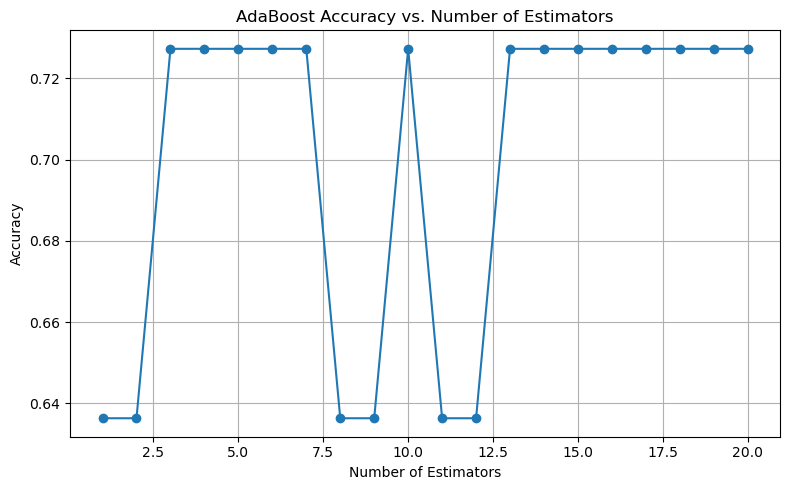

In [10]:
plot_adaboost_accuracy_vs_estimators(X_train, X_test, y_train, y_test, max_estimators=20)

### Discussion: Accuracy vs. Number of Estimators

The plot above shows how AdaBoost accuracy changes as we increase the number of decision stumps from 1 to 20. Unfortunately, the results are **unstable** and largely plateau around **72.7%**, with occasional sharp dips down to ~63.6%. This inconsistency suggests that adding more estimators is not reliably improving performance.

There are a few possible reasons for this:
- **Overfitting** on a specific train-test split.
- The dataset may still be small or noisy. 
- Model variance due to how samples are distributed in the current split. I think this is the one, and I will show it later down this notebook. For now, we try a different approach, that of working around a small dataset with cross-validation.

### Cross-Validation for AdaBoost

This function performs **k-fold cross-validation** to evaluate the AdaBoost classifier more robustly.

Instead of relying on a single train/test split (which can give misleading results depending on how the data is partitioned), k-fold cross-validation splits the dataset into *k* equally sized folds. The model is trained on *k-1* folds and tested on the remaining fold. This is repeated *k* times so that every data point is used for both training and testing exactly once.

Key points about the function:
- For each fold:
  - A new AdaBoost model is trained on the training portion.
  - Accuracy is computed on the validation portion.
- All fold accuracies are printed, and their mean is returned as a summary metric.

This approach helps **reduce the variance** of our evaluation and gives us a more reliable sense of whether AdaBoost is improving performance across different subsets of the data.

In [11]:
def cross_val_adaboost(X, y, n_estimators=10, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = AdaBoost(n_estimators=n_estimators)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        print(f"Fold {fold} Accuracy: {acc:.4f}")

    mean_acc = np.mean(accuracies)
    print(f"\nMean 5-Fold Accuracy: {mean_acc:.4f}")
    return accuracies


In [12]:
accuracies = cross_val_adaboost(X, y, n_estimators=10, k=5)

Fold 1 Accuracy: 0.7273
Fold 2 Accuracy: 0.4545
Fold 3 Accuracy: 0.8000
Fold 4 Accuracy: 0.7000
Fold 5 Accuracy: 0.8000

Mean 5-Fold Accuracy: 0.6964


### Discussion: Cross-Validation Results

The 5-fold cross-validation results show a **wide range of accuracies** across different folds — from as low as 45.5% to as high as 80%. The mean accuracy across all folds is **69.6%**, slightly lower than the original single-split result of 72.7%.

Rather than immediately trying to optimize hyperparameters or rebalance the data again, a helpful next step is to **visualize how the model is performing** in more detail. One effective way to do this is through **confusion matrices**, which break down the predictions into true positives, true negatives, false positives, and false negatives, as soon in other folders inside this git repo.

This visualization will help us better understand where the model is making mistakes — for instance, whether it is misclassifying most of the "died" cases or struggling with both classes equally.

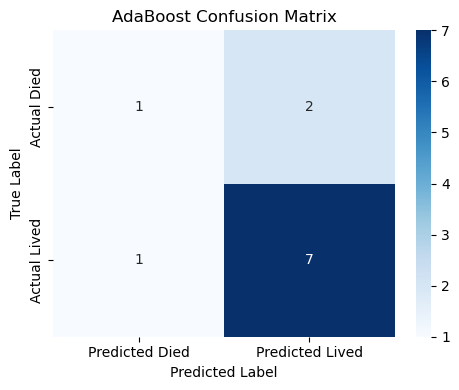

In [8]:
# Convert labels back to 0 and 1 for easier interpretation
y_test_binary = np.where(y_test == -1, 0, 1)
y_pred_binary = np.where(y_pred == -1, 0, 1)

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Died', 'Predicted Lived'],
            yticklabels=['Actual Died', 'Actual Lived'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('AdaBoost Confusion Matrix')
plt.tight_layout()
plt.show()


### Confusion Matrix: AdaBoost Classification

The confusion matrix shown above reveals a **notable bias toward predicting survival**:

- The model predicts many more horses as "lived" than "died."
- Most of the false predictions are **false positives** — horses predicted to live that actually died.

This imbalance may stem from:
- The dataset being skewed toward survivors.

This suggests that balancing the classes may fix the problmem. So, we try that approach:

## New Approach to Improve Accuracy: Balanced Classes (of Deaths and Survivals) in the Training Data Set

### Balancing the Dataset to Improve Accuracy

Previously, the model was trained on a dataset with an **uneven distribution of outcomes**, where the majority of horses had survived. This class imbalance likely contributed to the model's tendency to overpredict survival and underperform on identifying deaths.

To address this, we try to **balance the training dataset**, to get an equal number of horses who died as those who survived.

In [17]:
# Trying to see if having equal deaths and surivor horses will make a difference in accuracy
df_binary = df_clean[df_clean['outcome'].isin([0, 1])]

# Separate classes
df_lived = df_binary[df_binary['outcome'] == 1]
df_died = df_binary[df_binary['outcome'] == 0]

# Balance the classes
min_class_size = min(len(df_lived), len(df_died))
df_balanced = pd.concat([df_lived.sample(min_class_size, random_state=42),
                         df_died.sample(min_class_size, random_state=42)])

# Shuffle the result
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Define X and y
X_balanced = df_balanced.drop(columns=['outcome']).values
y_balanced = df_balanced['outcome'].values
y_balanced = np.where(y_balanced == 1, 1, -1)  # AdaBoost expects -1/+1

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

### Running everything again to see improved results

#### Improved Accuracy = 1 > .7273

In [22]:
# Initialize the AdaBoost model with an arbitrary number of weak learners (decision stumps) (n=10)
model = AdaBoost(n_estimators=10)

# Train the AdaBoost model on the training data
# This involves sequentially training weak learners and updating sample weights
model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set using the trained ensemble
y_pred = model.predict(X_test_balanced)

# Evaluate the model by comparing predicted labels with true labels
# Accuracy is the proportion of correctly predicted samples
acc = accuracy_score(y_test_balanced, y_pred)

# Print the result with four decimal places
print(f"AdaBoost Accuracy: {acc:.4f}")

AdaBoost Accuracy: 1.0000


#### Improved Accuracy as Number of Estimators Increases

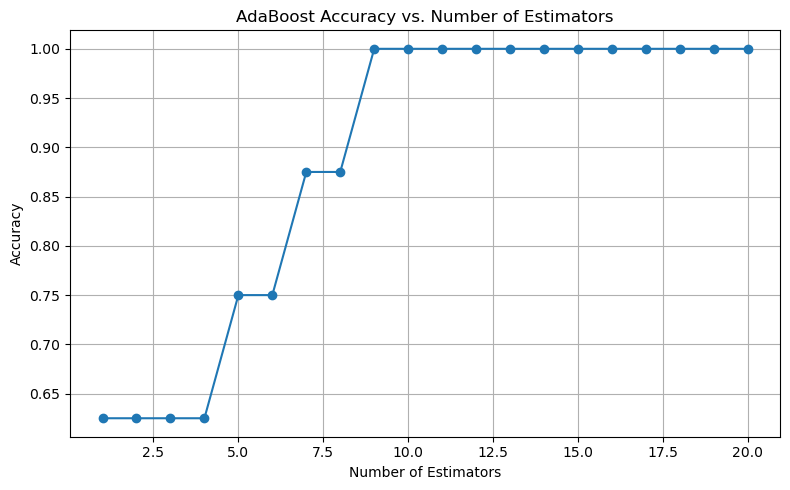

In [23]:
plot_adaboost_accuracy_vs_estimators(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced, max_estimators=20)

This plot shows the accuracy of AdaBoost as a function of the number of estimators (decision stumps) using the balanced dataset (equal numbers of horses that lived and died).

Initially, accuracy is around 63%, similar to earlier results before balancing. However, after just a few estimators (around 5–8), accuracy steadily improves. By n = 9, the model reaches 100% accuracy and maintains it through the rest of the range (n = 10 to 20).

This dramatic improvement illustrates how balancing the classes has a major effect on boosting performance. When both classes are equally represented, the AdaBoost algorithm can more effectively focus its stumps on the hardest-to-classify cases without being biased toward the majority class.

#### (Slightly less) Improved Accuracies with Cross-validation = 0.7143 > 0.6964

In [26]:
accuracies = cross_val_adaboost(X_balanced, y_balanced, n_estimators=10, k=5)

Fold 1 Accuracy: 1.0000
Fold 2 Accuracy: 0.4286
Fold 3 Accuracy: 0.7143
Fold 4 Accuracy: 0.7143
Fold 5 Accuracy: 0.7143

Mean 5-Fold Accuracy: 0.7143


# Improved Confusion Matrix

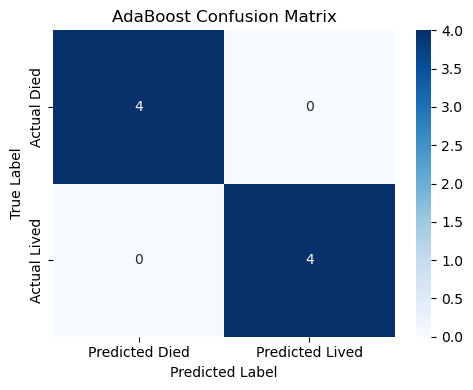

In [27]:
# Convert labels back to 0 and 1 for easier interpretation
y_test_binary = np.where(y_test_balanced == -1, 0, 1)
y_pred_binary = np.where(y_pred == -1, 0, 1)

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Died', 'Predicted Lived'],
            yticklabels=['Actual Died', 'Actual Lived'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('AdaBoost Confusion Matrix')
plt.tight_layout()
plt.show()